# 1. Import packages and Data

In [56]:
import os
import kagglehub
from dotenv import load_dotenv
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

load_dotenv("./config/.env")

#supress warnings
import warnings
warnings.filterwarnings("ignore")

In [43]:
# Download latest version
path = kagglehub.dataset_download("maajdl/yeh-concret-data")

print("Path to dataset files:", path)

100%|██████████| 10.2k/10.2k [00:00<00:00, 10.5MB/s]

Extracting files...
Path to dataset files: C:\Users\bruno\.cache\kagglehub\datasets\maajdl\yeh-concret-data\versions\1


In [57]:
df = pd.read_csv(f"{path}/{os.environ["FILE_NAME"]}")
display(df)
display(df.info())
display(df.describe())

cement   slag  flyash  water  ...  coarseaggregate  fineaggregate  age  csMPa
0      540.0    0.0     0.0  162.0  ...           1040.0          676.0   28  79.99
1      540.0    0.0     0.0  162.0  ...           1055.0          676.0   28  61.89
2      332.5  142.5     0.0  228.0  ...            932.0          594.0  270  40.27
3      332.5  142.5     0.0  228.0  ...            932.0          594.0  365  41.05
4      198.6  132.4     0.0  192.0  ...            978.4          825.5  360  44.30
...      ...    ...     ...    ...  ...              ...            ...  ...    ...
1025   276.4  116.0    90.3  179.6  ...            870.1          768.3   28  44.28
1026   322.2    0.0   115.6  196.0  ...            817.9          813.4   28  31.18
1027   148.5  139.4   108.6  192.7  ...            892.4          780.0   28  23.70
1028   159.1  186.7     0.0  175.6  ...            989.6          788.9   28  32.77
1029   260.9  100.5    78.3  200.6  ...            864.5          761.5   28  32.40

[1030 rows x 9 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cement            1030 non-null   float64
 1   slag              1030 non-null   float64
 2   flyash            1030 non-null   float64
 3   water             1030 non-null   float64
 4   superplasticizer  1030 non-null   float64
 5   coarseaggregate   1030 non-null   float64
 6   fineaggregate     1030 non-null   float64
 7   age               1030 non-null   int64  
 8   csMPa             1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.6 KB


None

cement         slag  ...          age        csMPa
count  1030.000000  1030.000000  ...  1030.000000  1030.000000
mean    281.167864    73.895825  ...    45.662136    35.817961
std     104.506364    86.279342  ...    63.169912    16.705742
min     102.000000     0.000000  ...     1.000000     2.330000
25%     192.375000     0.000000  ...     7.000000    23.710000
50%     272.900000    22.000000  ...    28.000000    34.445000
75%     350.000000   142.950000  ...    56.000000    46.135000
max     540.000000   359.400000  ...   365.000000    82.600000

[8 rows x 9 columns]

# 2. Initial EDA and Distributions

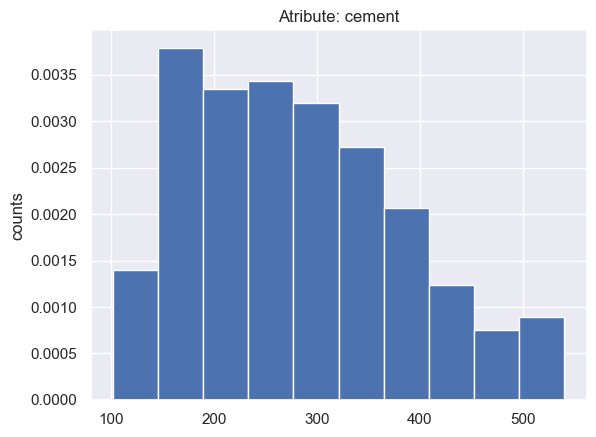

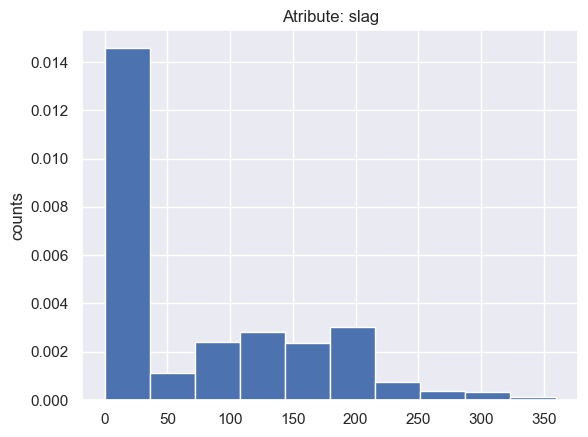

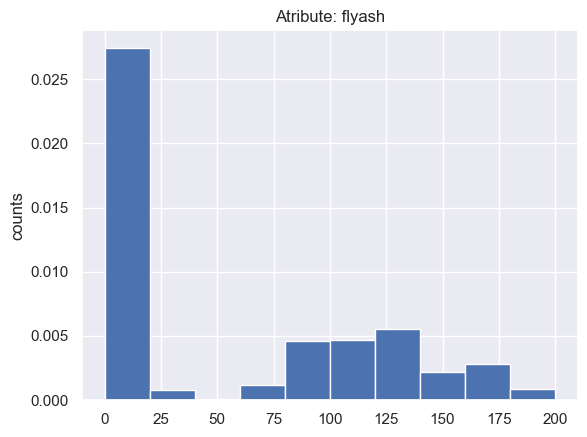

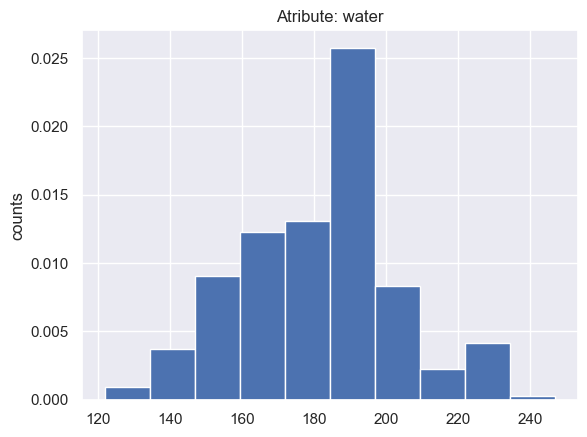

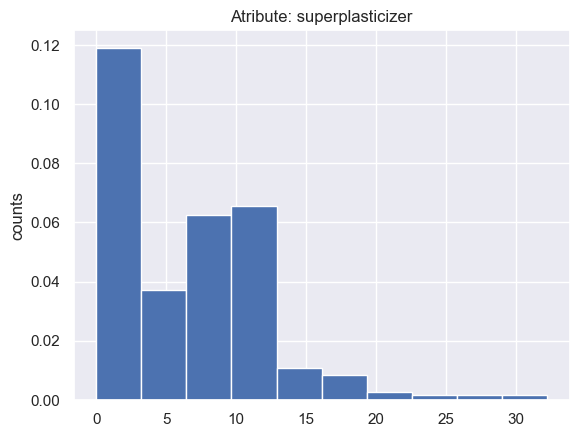

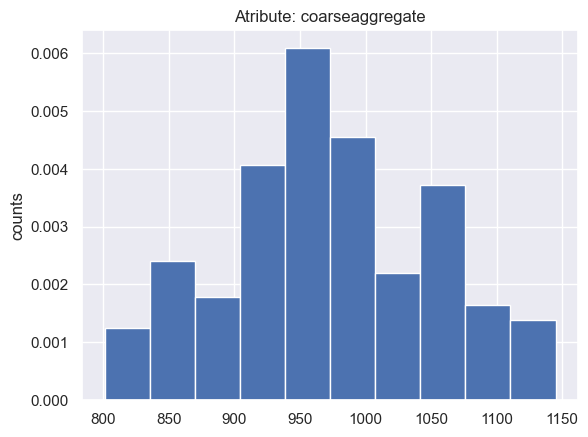

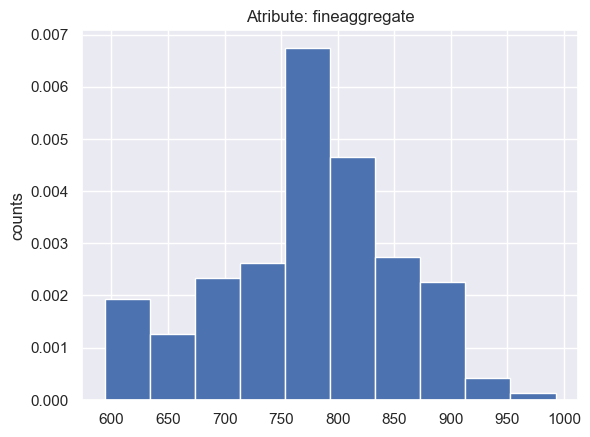

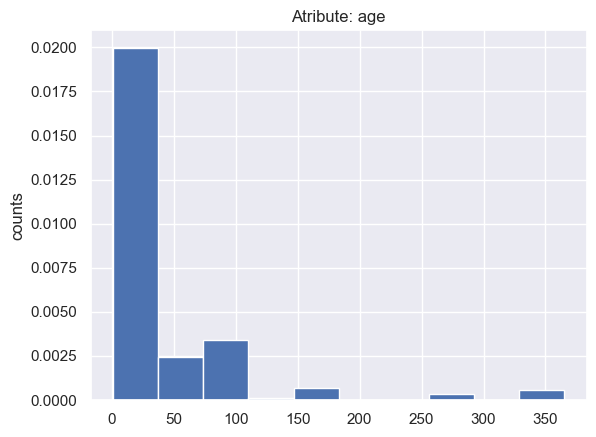

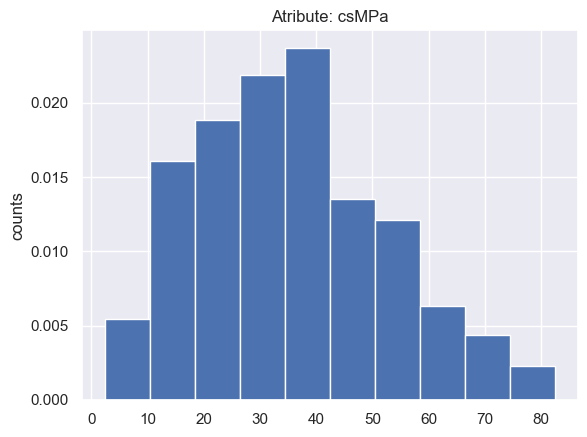

In [5]:
#look at data distribution
for column in df.columns:
    plt.hist(df[column], density=True)
    plt.title(f"Atribute: {column}")
    plt.xticks()
    plt.ylabel('counts')
    plt.show()

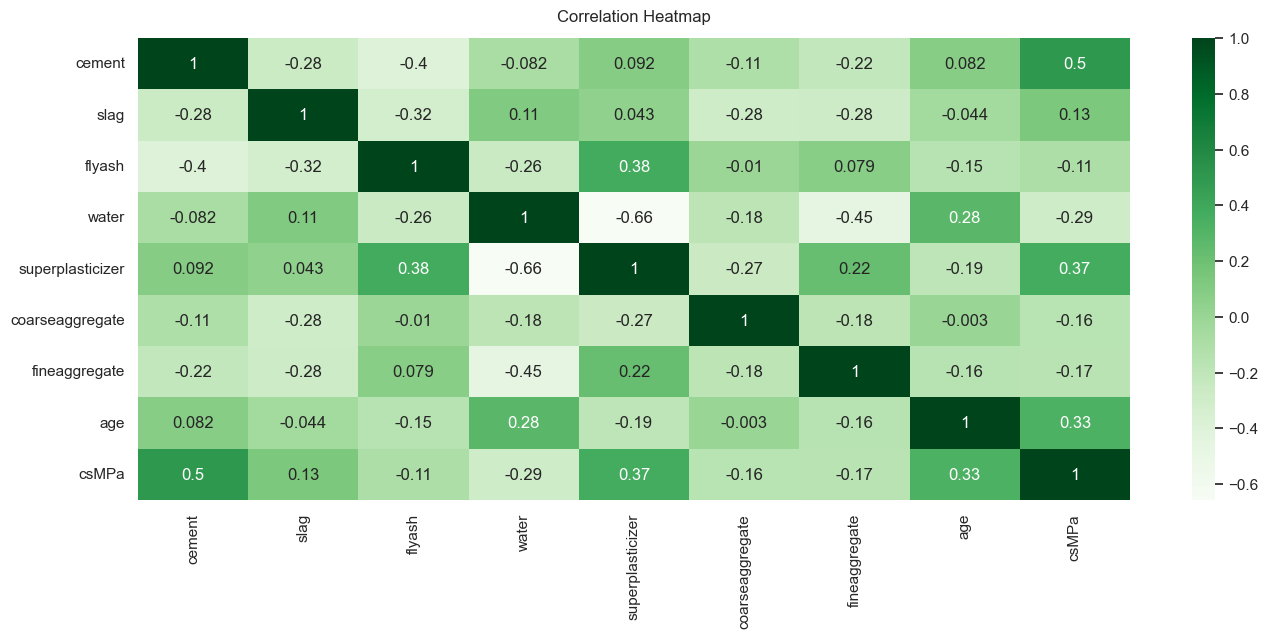

In [6]:
plt.figure(figsize=(16, 6))
sns.heatmap(df.corr(), annot=True, cmap="Greens")
plt.title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.show()

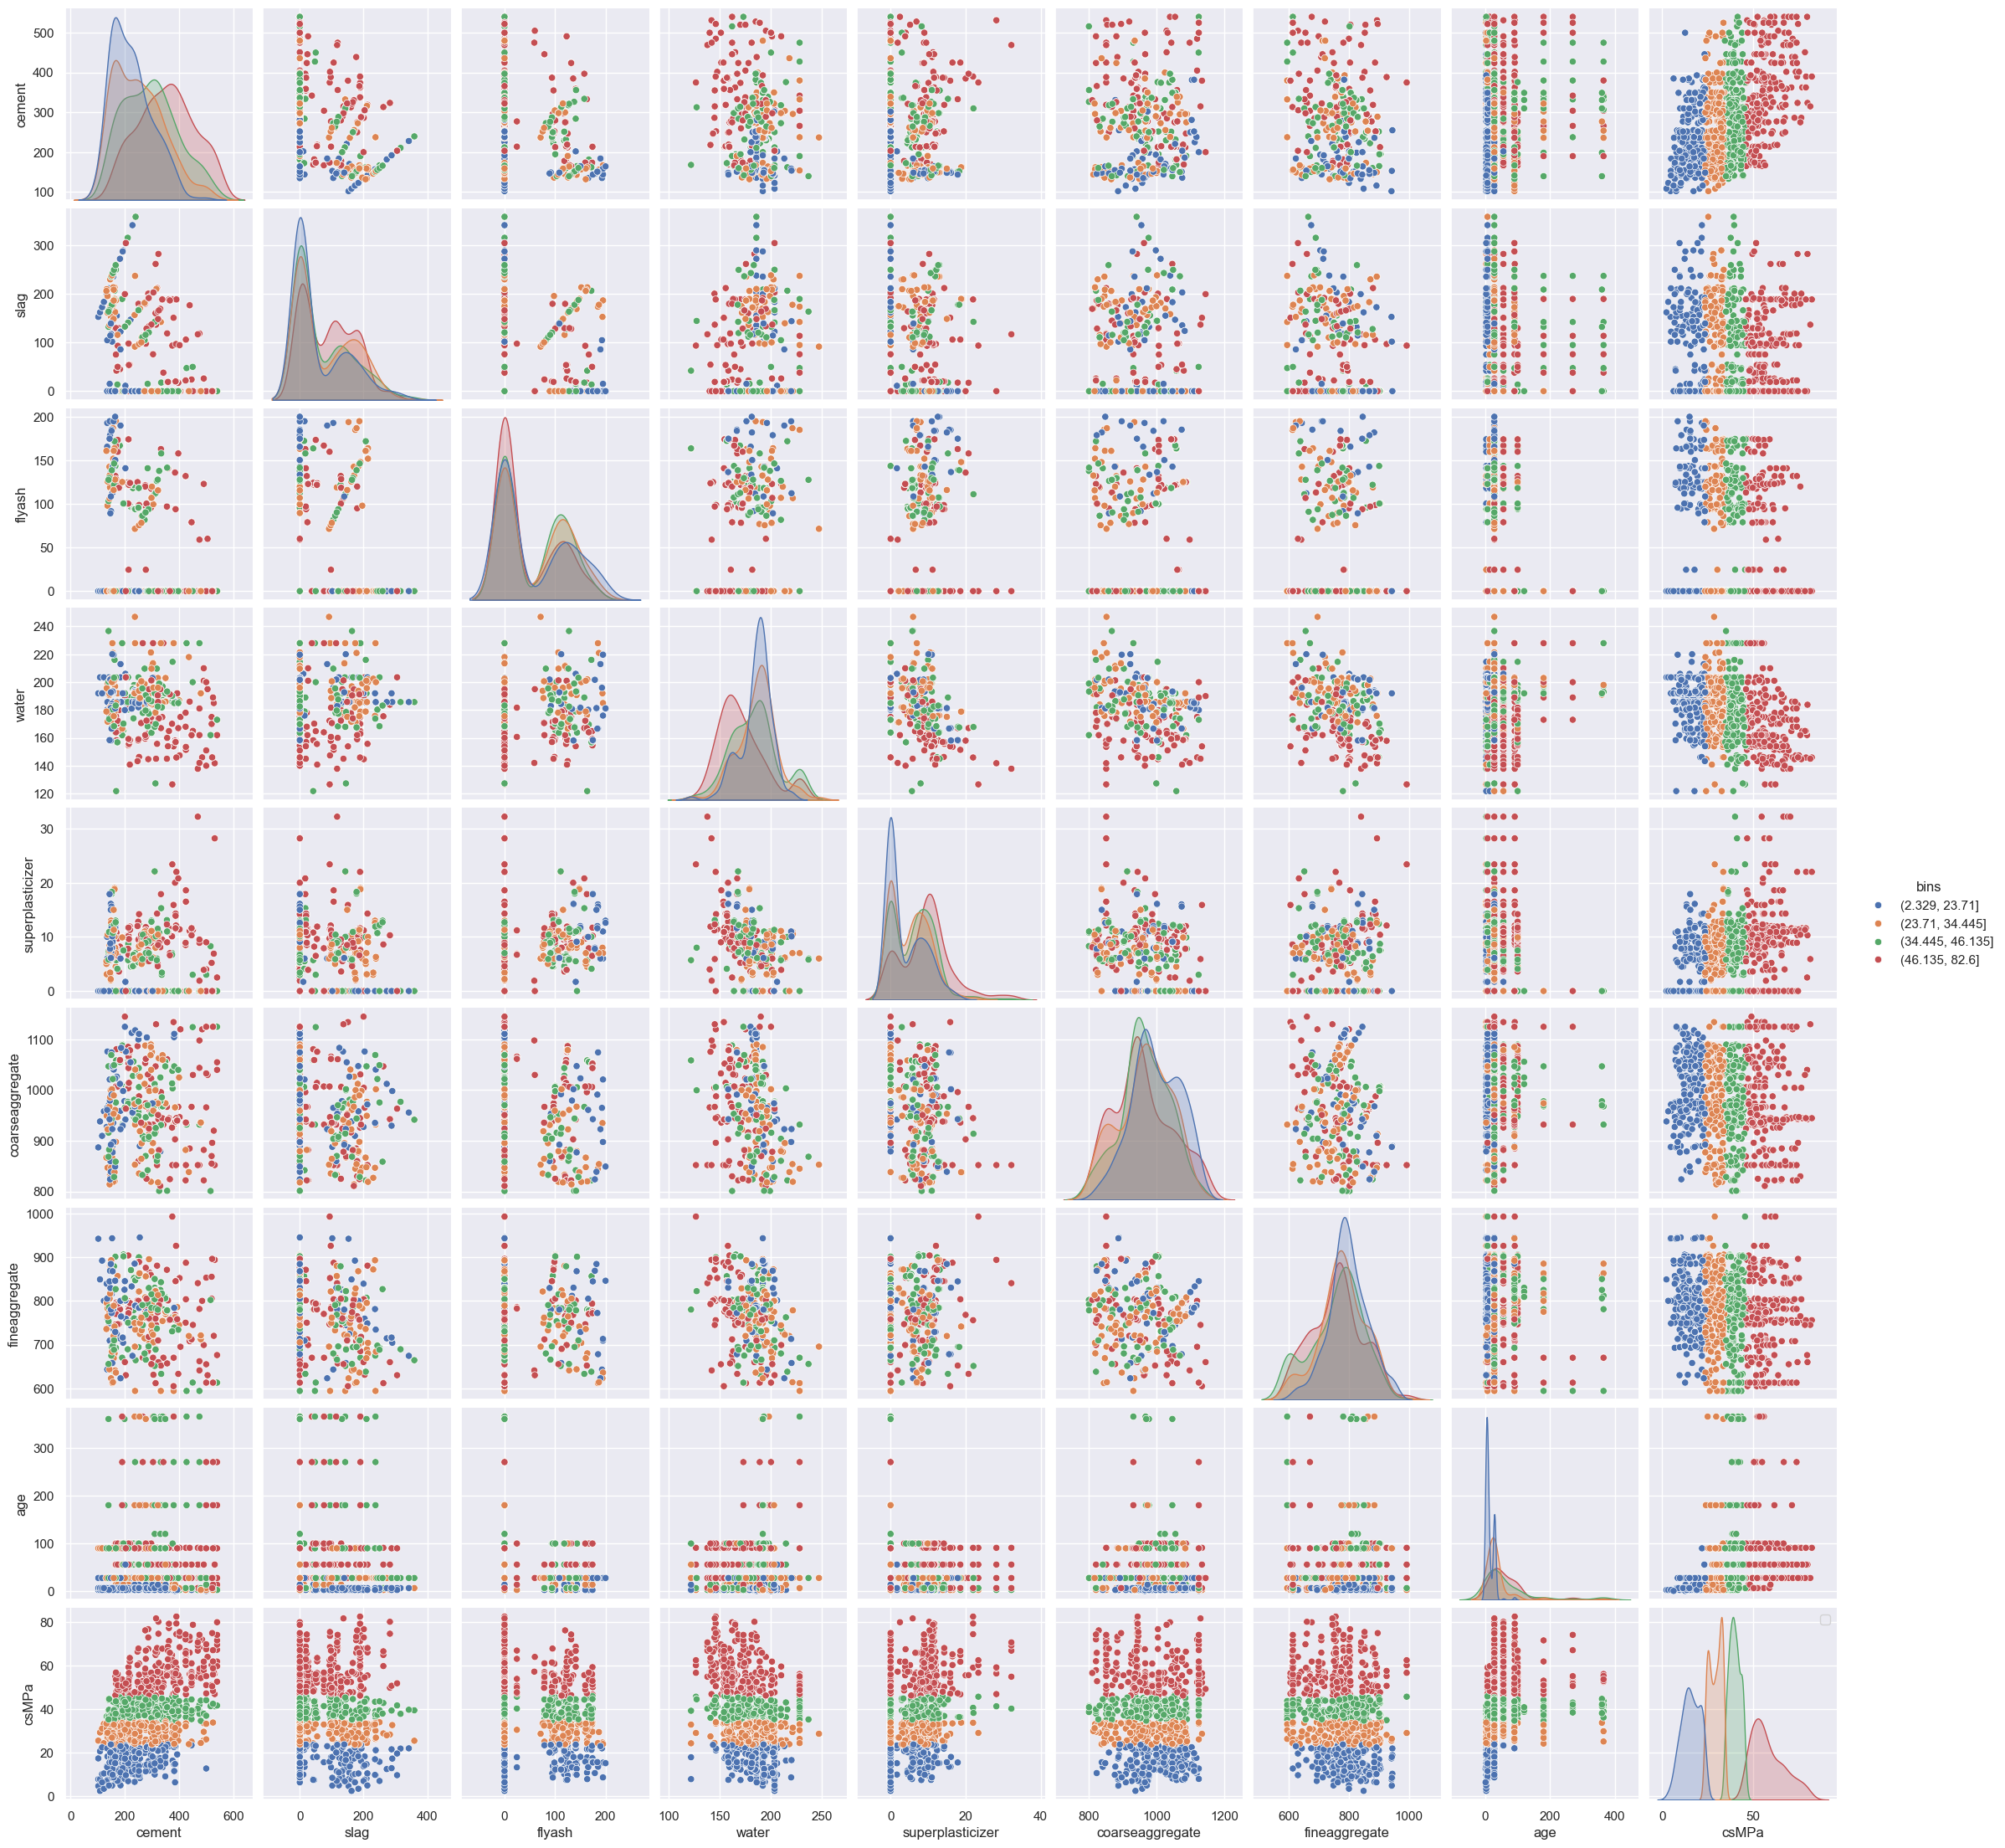

In [7]:
# Discretizar dados da coluna csMPa em intervalos de mesma largura
bins = pd.qcut(df['csMPa'], q=4)

df['bins'] = bins

# Analisar se existe uma correlação linear entre os atributos separados por classe
sns.pairplot(df.loc[:, (df.columns)], hue='bins')
plt.legend()
plt.show()

Pode-se notar que o atributo "cement" tem a melhor correlação linear com "csMPa" (o atributo alvo), os demais atributos não apresentam correlações lineares tão diretas quanto ela. Além do as classes ficam bem separadas nessa correlação linear.

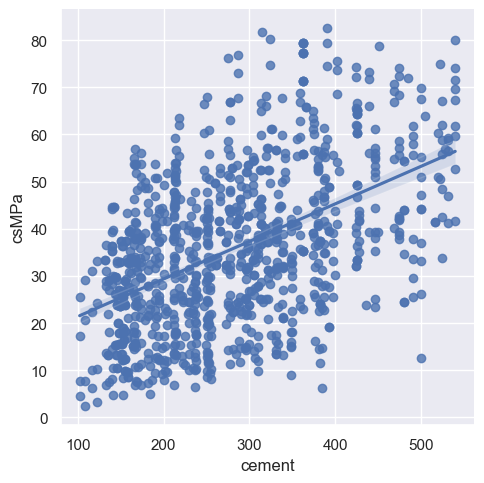

In [8]:
sns.lmplot(x='cement', y='csMPa',data=df)
plt.show()

In [9]:
df = df.drop('bins', axis=1)

X = df.copy()
Y = X.pop('csMPa')

# 3. Principal Component Analysis

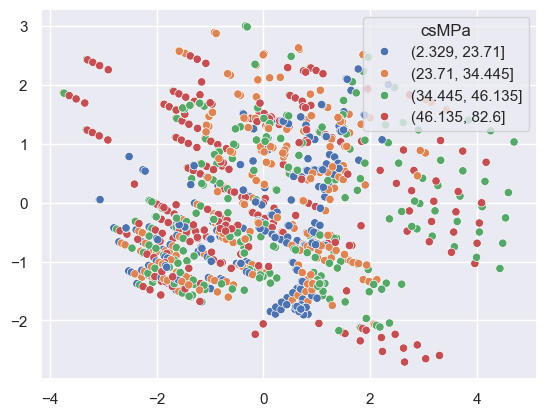

In [69]:
X_for_PCA = X.copy()

scaler = StandardScaler()
X_for_PCA_scaled = scaler.fit_transform(X_for_PCA.values)

pca = PCA(len(X.columns))
X_pca = pca.fit_transform(X_for_PCA_scaled)

component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

sns.scatterplot(x=X_pca["PC1"].values, y=X_pca["PC2"].values, hue=bins)
plt.show()

In [72]:
print(pca.components_)

[[ 0.09840137  0.17726197 -0.39466185  0.54700395 -0.50594541  0.03792808
  -0.40192597  0.29147949]
 [-0.11373709  0.6860529  -0.14294751  0.05325628  0.2829296  -0.62994342
  -0.01939111 -0.12598089]
 [ 0.81420224 -0.17179437 -0.40822055 -0.21318975  0.23459653 -0.17408781
  -0.00456921  0.10052137]
 [ 0.054297    0.36269932 -0.2267512  -0.29606003  0.03727351  0.54580513
  -0.38528206 -0.52791909]
 [-0.14820612  0.02093167 -0.54963115 -0.07022191 -0.35461841  0.03308317
   0.70123743 -0.22801019]
 [-0.20314214  0.30488197 -0.1832672  -0.36597033  0.19329372  0.31455942
   0.09246568  0.743908  ]
 [-0.22184381 -0.22836331 -0.35246257  0.52427468  0.66464314  0.22684015
   0.03902583 -0.06936667]
 [ 0.44616267  0.43738376  0.38188581  0.38874117  0.05174995  0.34931986
   0.43336994  0.01288097]]


Os loadings(cargas) medem o quanto cada atributo original contribui para cada PC. Mais especificamente, cada linha do dataframe de loadings abaixo é o cosseno do ângulo entre a atributo original e os PCs. Eles representam a correlação entre os atributos originais e os PCs.

In [73]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=component_names,
    index=X.columns,
)
display(loadings)

PC1       PC2       PC3       PC4       PC5       PC6  \
cement            0.098401 -0.113737  0.814202  0.054297 -0.148206 -0.203142   
slag              0.177262  0.686053 -0.171794  0.362699  0.020932  0.304882   
flyash           -0.394662 -0.142948 -0.408221 -0.226751 -0.549631 -0.183267   
water             0.547004  0.053256 -0.213190 -0.296060 -0.070222 -0.365970   
superplasticizer -0.505945  0.282930  0.234597  0.037274 -0.354618  0.193294   
coarseaggregate   0.037928 -0.629943 -0.174088  0.545805  0.033083  0.314559   
fineaggregate    -0.401926 -0.019391 -0.004569 -0.385282  0.701237  0.092466   
age               0.291479 -0.125981  0.100521 -0.527919 -0.228010  0.743908   

                       PC7       PC8  
cement           -0.221844  0.446163  
slag             -0.228363  0.437384  
flyash           -0.352463  0.381886  
water             0.524275  0.388741  
superplasticizer  0.664643  0.051750  
coarseaggregate   0.226840  0.349320  
fineaggregate     0.039026  0.433370  
age              -0.069367  0.012881

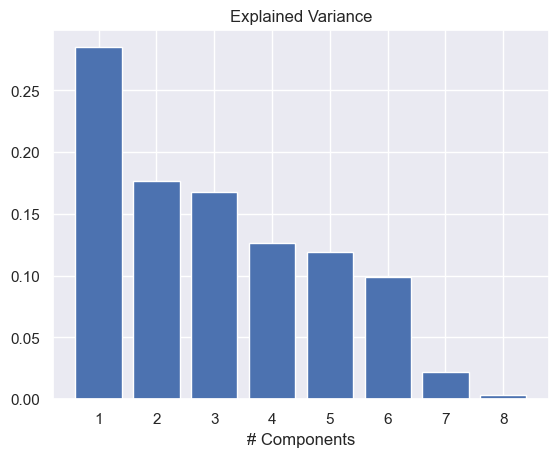

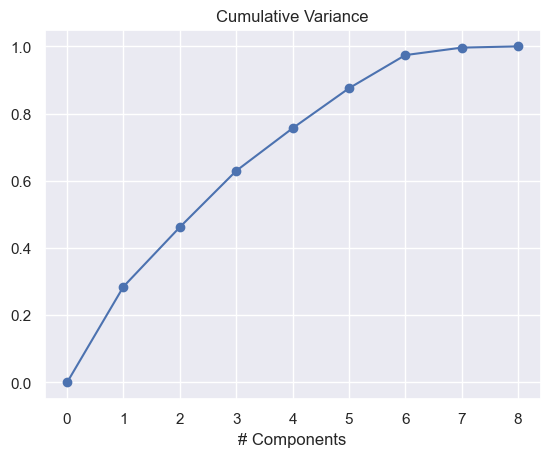

In [79]:
grid = np.arange(1, pca.n_components_+1)
explained_var_ratio = pca.explained_variance_ratio_

plt.figure()
plt.title("Explained Variance")
plt.xlabel("# Components")
plt.bar(grid, explained_var_ratio)
plt.show()

plt.figure()
plt.plot(np.r_[0, grid], np.r_[0, np.cumsum(explained_var_ratio)], "o-")
plt.title("Cumulative Variance")
plt.xlabel("# Components")
plt.show()

# 4. OLS (Ordinary Least Squares) Regression Analysis

In [10]:
X_sm = sm.add_constant(X)
model = sm.OLS(Y, X_sm).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  csMPa   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     204.3
Date:                dom, 06 abr 2025   Prob (F-statistic):          6.29e-206
Time:                        16:13:32   Log-Likelihood:                -3869.0
No. Observations:                1030   AIC:                             7756.
Df Residuals:                    1021   BIC:                             7800.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -23.3312     26.586  

**Questão 1: Há alguma relação entre os preditores (age e ingredientes) e a variável aleatória (`compressive strength`)?**

**Hipótese nula (H0): Coeficientes para cada preditor é zero**

A Estatística-F (F-statistic) igual a 204.3 (204.3 >> 1) indica que há pelo menos uma variável preditora que se correlaciona com a `compressive strength`. A probabilidade da Estatística-F de 6.29e-206 indica a probabilidade da hipótese nula. Portanto existe correlação entre preditores e variável de resposta.

**Questão 2: O quão forte é a relação entre preditores e variável de resposta?**

A métrica R² indica o quanto o modelo consegue explicar a variável de resposta, ou seja, 61.6% da variância é explicada pelo modelo.

**Questão 3: Quais preditores contribuem para a `compressive strength`?**

O p-value de cada estatística-t para os preditores indica se deve-se ou não aceitar H0. Considerando um nível de significância de alpha=5% (0.05), os únicos preditores com p-value menor que alpha são `superplasticizer` e `coarseaggregate`, portanto eles não contribuem significantemente para a `compressive strength`.

**Questão 4: O quão grande é o efeito de cada preditor na `compressive strength`?**

O único atributo a apresentar coeficiente igual a zero em seu intervalo de confiança  é o `coarseaggregate`. Os demais atributos são considerados, estatisticamente, significantes. Mas, para validar se a colinearidade é o motivo do intervalo de confiança para o `coarseaggregate` chegar em zero, serão estimados os VIF scores.

In [12]:
vif_scores = []
for idx, column in enumerate(X.columns):
    vif_scores.append(variance_inflation_factor(X.values, idx))

vif_df = pd.DataFrame({"feature": X.columns, "vif": vif_scores})
display(vif_df)

feature        vif
0            cement  15.456717
1              slag   3.329127
2            flyash   4.147833
3             water  82.157569
4  superplasticizer   5.471094
5   coarseaggregate  84.955779
6     fineaggregate  72.790995
7               age   1.699459

**O VIF score com valores entre 5 e 10 indicam colinearidade, onde 1 é a colinearidade mínima.**

Os atributos `water` e `cement` exibem uma multicolinearidade. `Superplasticizer` está no range entre 5 e 10, portanto, sendo conservativo, ele demonstra colinearidade. Portanto, não evidências o suficiente para apontar que `coarseaggregate` não é estatisticamente insignificante, afinal, seu intervalo de confiança largo pode ter chegado em zero devida a multicolinearidade.

Portanto, é possível estudar a associação de cada preditor com a `compressive strength`, executando um OLS para cada atributo preditor:

In [27]:
for column in X.columns:
    X_sm = sm.add_constant(X[column])
    model = sm.OLS(Y, X_sm)
    
    text = f"\33[44m Atribute: {column} \33[0m" 
    print(text.center(90))
    print(model.fit().summary())

                                Atribute: cement                                 
                            OLS Regression Results                            
Dep. Variable:                  csMPa   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     338.7
Date:                dom, 06 abr 2025   Prob (F-statistic):           1.32e-65
Time:                        16:43:39   Log-Likelihood:                -4214.6
No. Observations:                1030   AIC:                             8433.
Df Residuals:                    1028   BIC:                             8443.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------

Observando o p-value da estatística-t, todos os atributos apresentam uma associação forte com a variável de resposta `compressive strength`. Sendo que `flyash` é a mais fraca entre elas e apresenta um p-value de 0.001

**Questão 5:** Qual a acurácia desse modelo para prever a `compressive strength`?

Essa acurácia vai depender do tipo de predição:
1. Resposta individual (Y = f(X) + ep), o intervalo de predição é usado
2. Resposta média (f(X)), o intervalo de confiança é usado

O intervalo de predição (2) são mais largos que os intervalos de confiança (1), isso se dá, pois são levados em conta as incertezas associadas ao erro irredutível (ep)

**Questão 6:** A relação é linear?

A não-linearidade pode ser determinada pelo plot do `resíduo vs valor predito` para cada atributo (plots do canto superior direito). Quando existe linearidade, deve haver um padrão bem claro. O plot do resíduo com a forma mais não-linear é quando o atributo `age` está entre 0 e 20, onde há resíduos negativos, aumentando de 20 até 100 até decaírem novamente. `water` e `fineaggregate` têm padrões levemente não-lineares. Transformações dos preditores (por exemplo: sqrt(X); X^2) podem acomodar as não-linearidades.

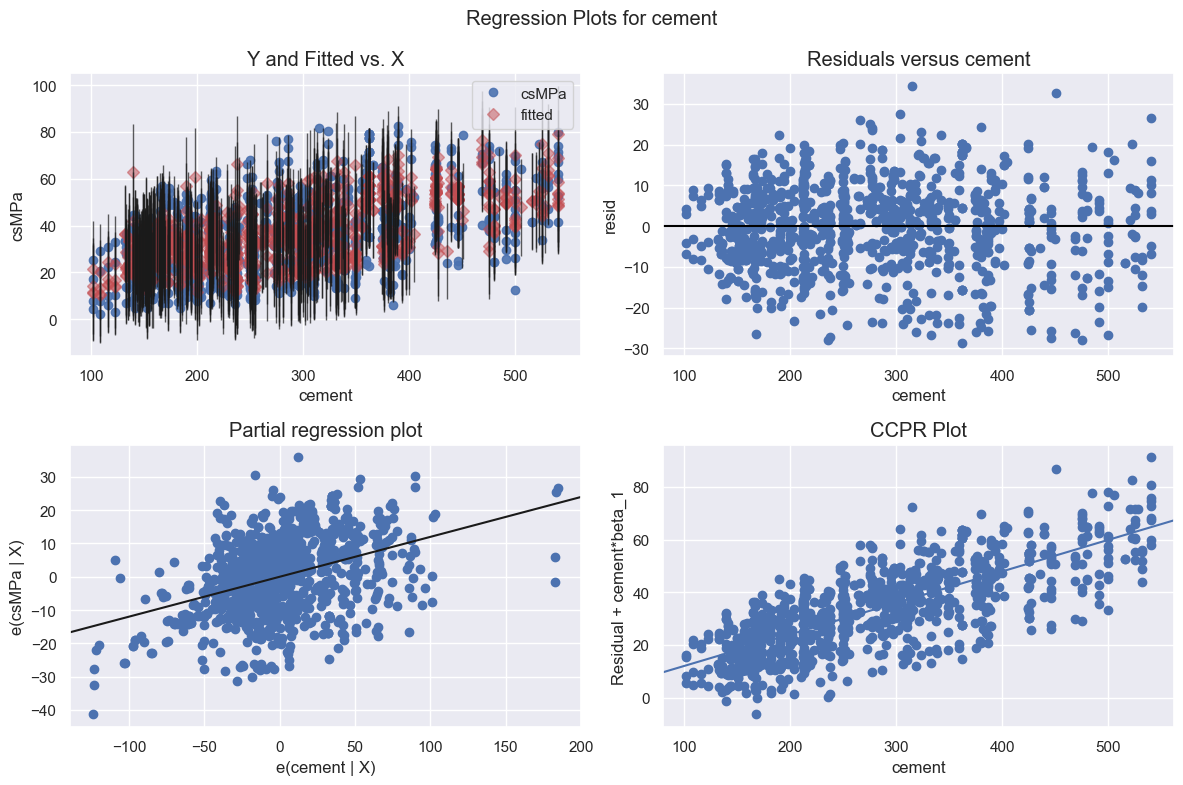

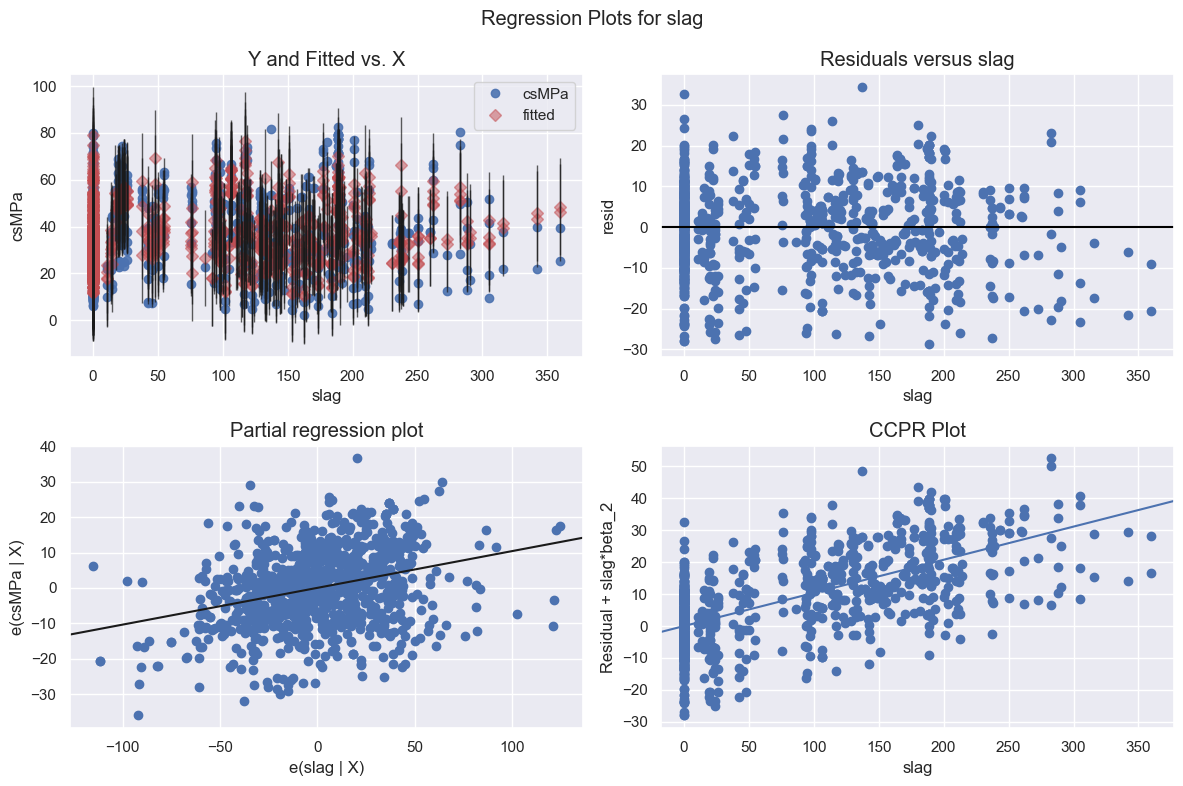

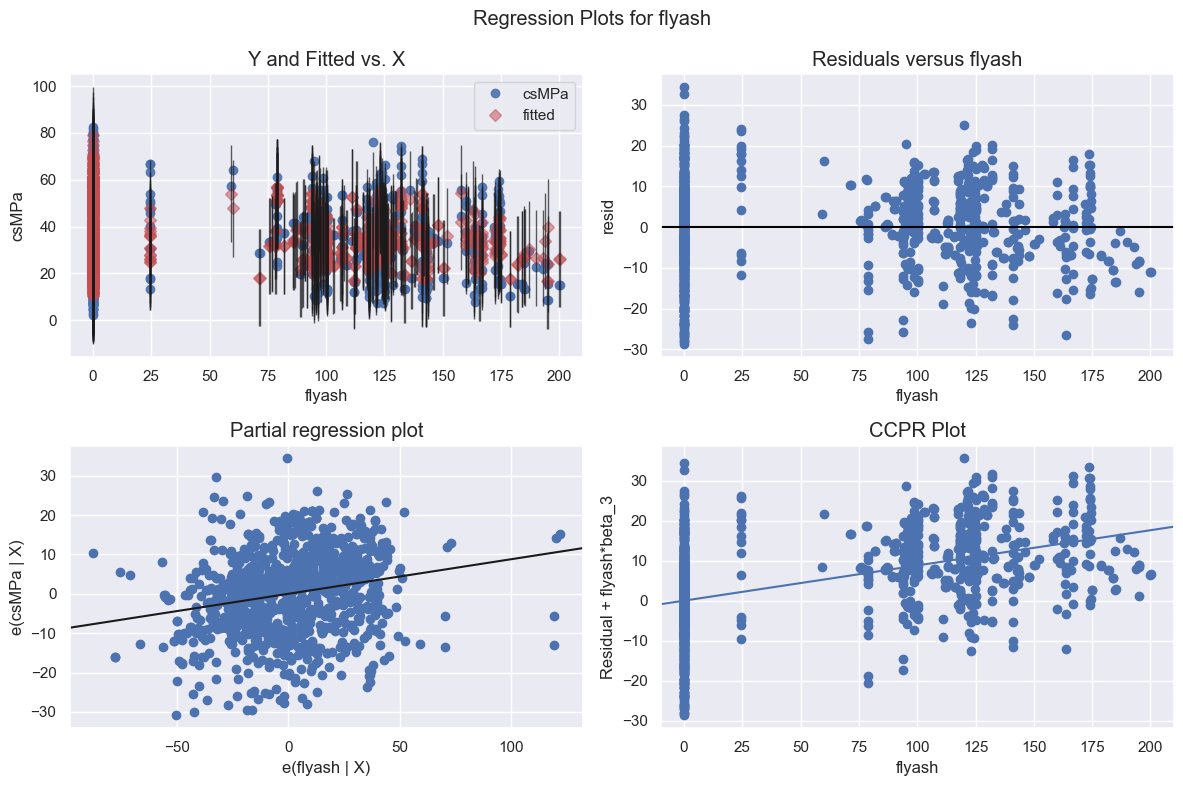

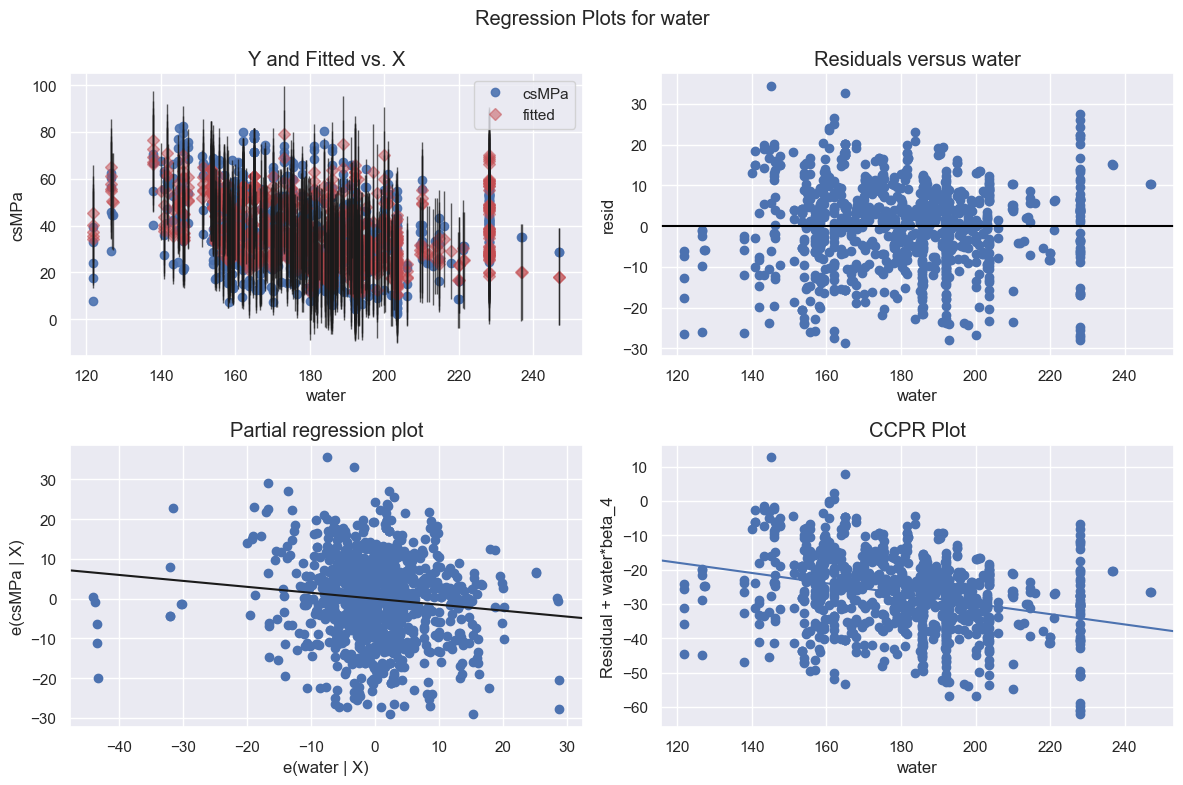

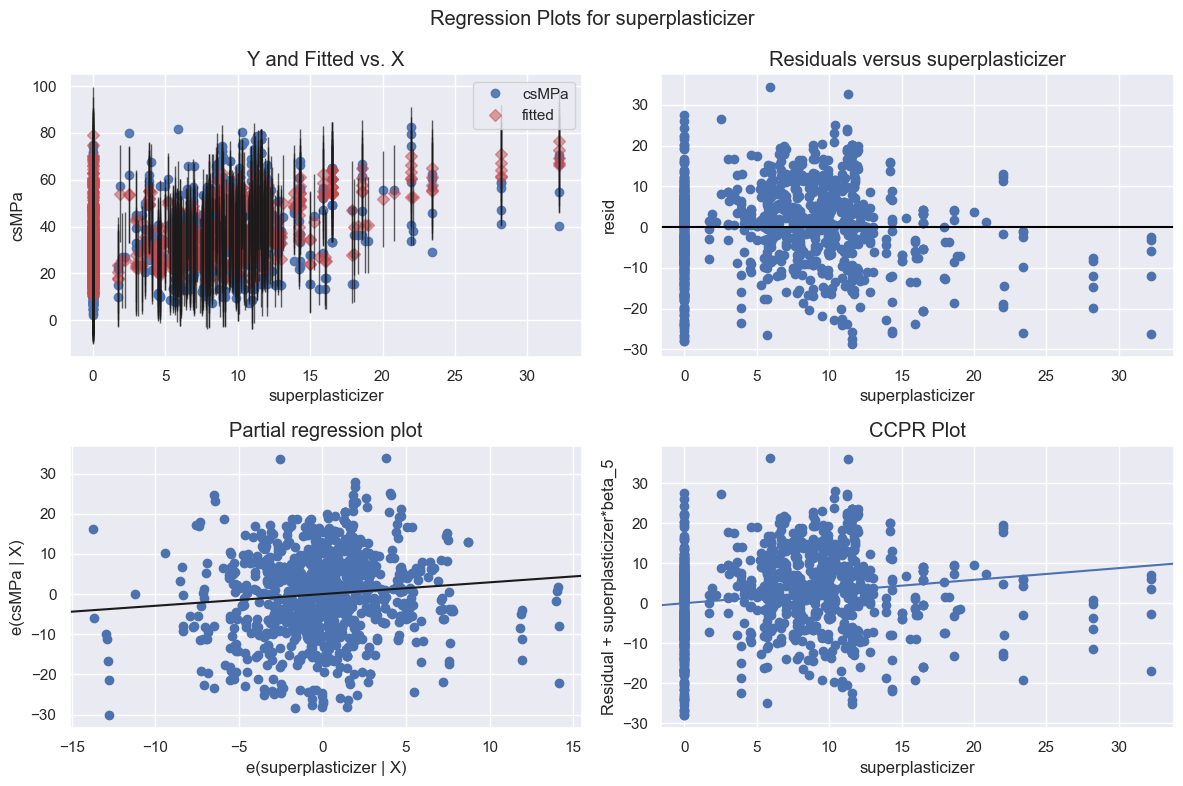

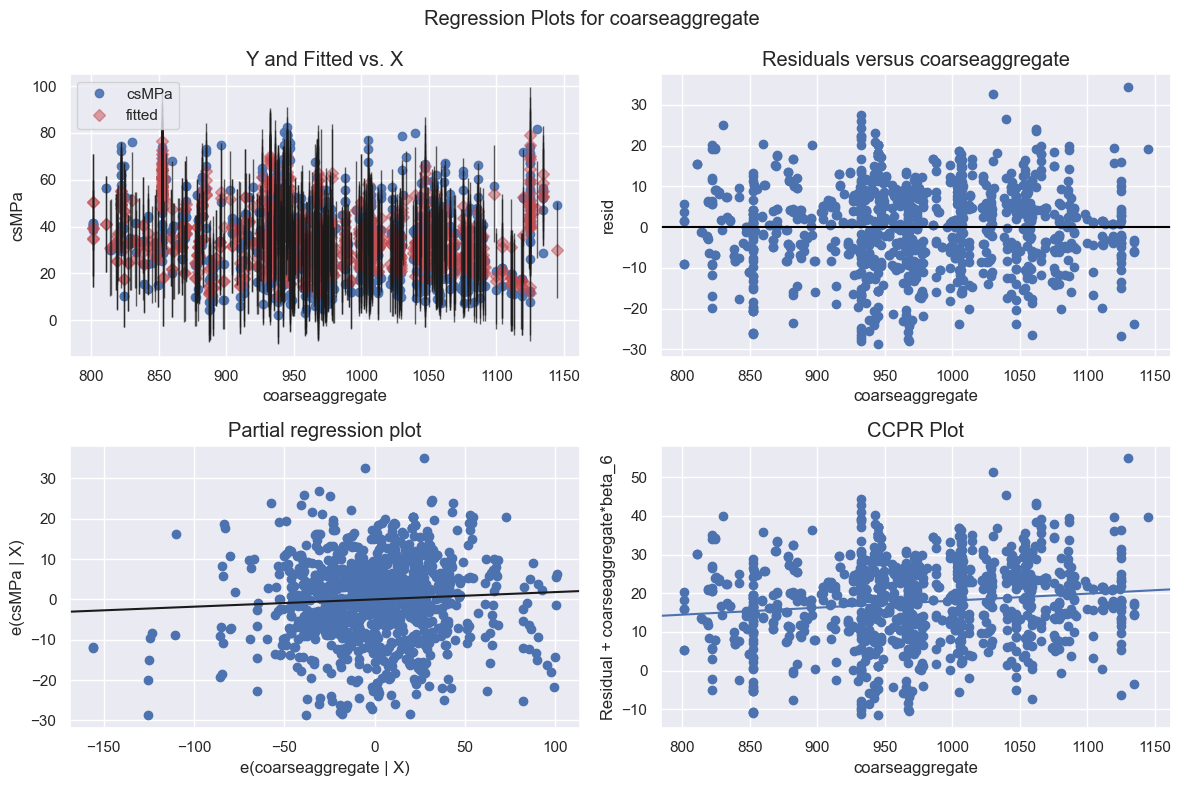

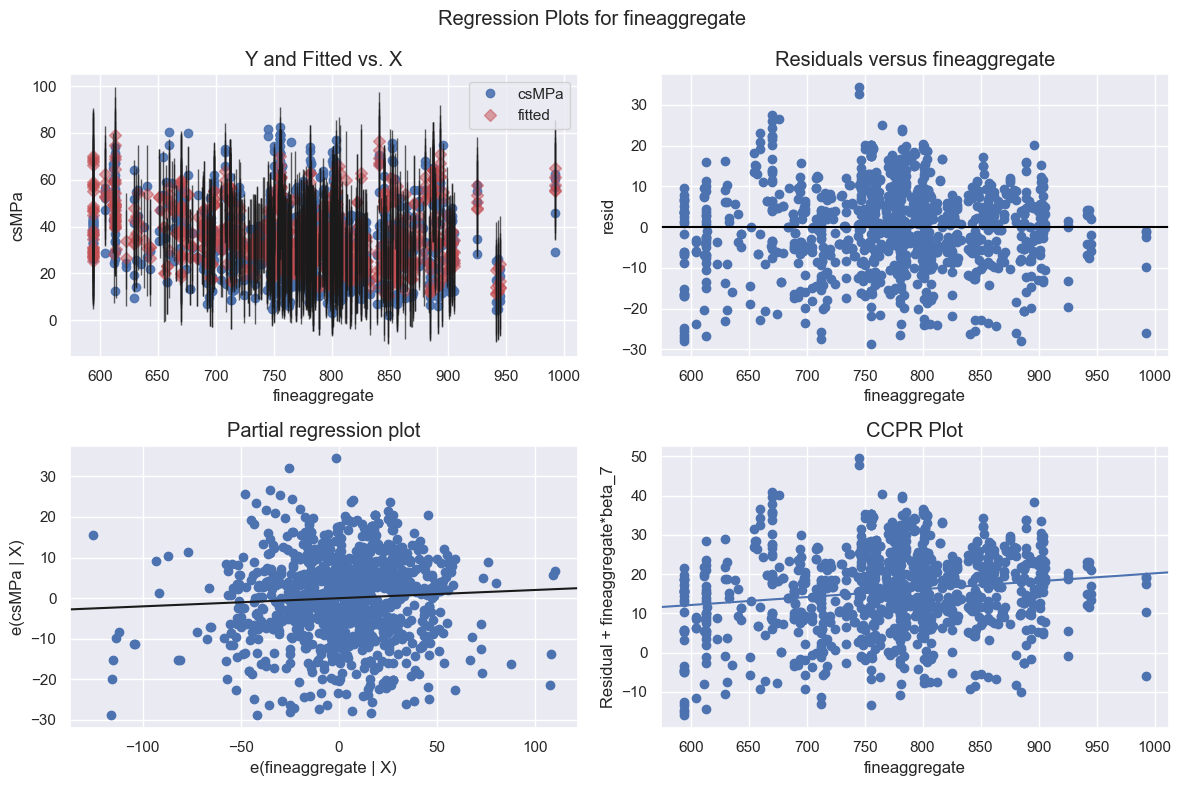

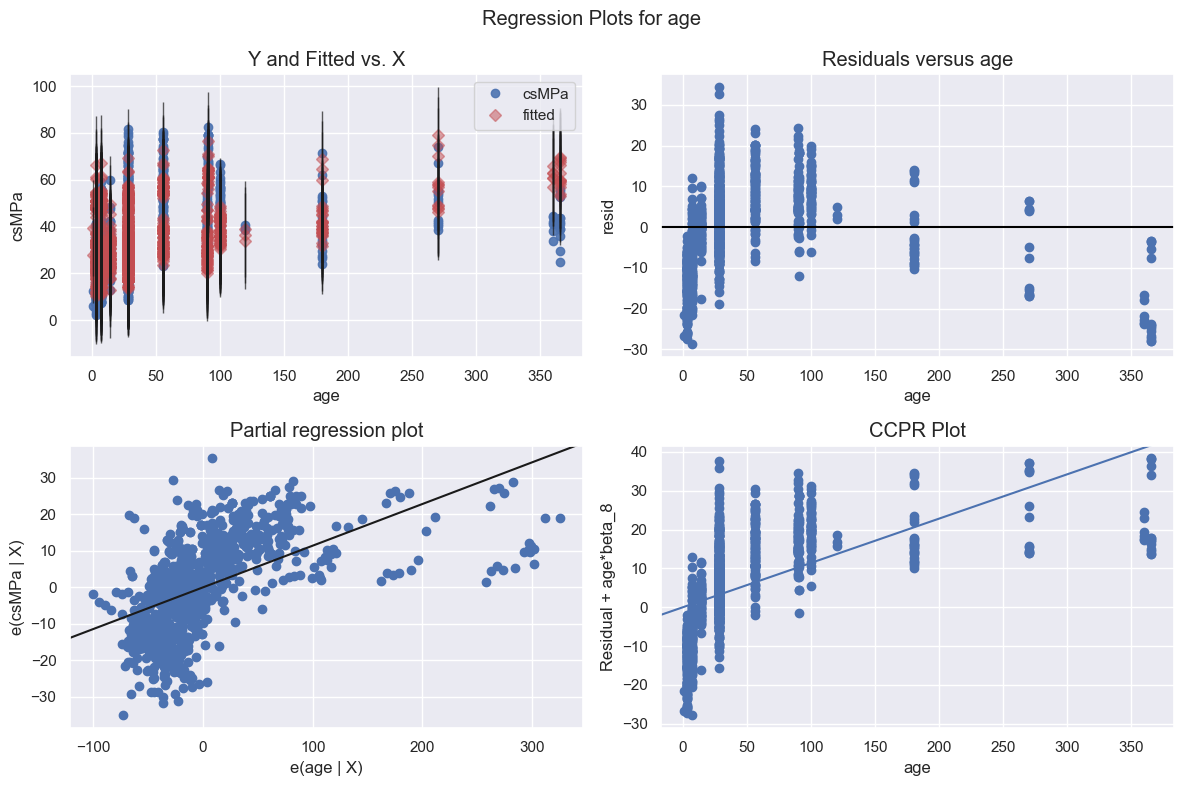

In [30]:
model = ols('csMPa ~ cement + slag + flyash + water + superplasticizer + coarseaggregate + fineaggregate + age', data=df).fit()

for column in X.columns:
    fig = plt.figure(figsize=(12,8))
    fig = sm.graphics.plot_regress_exog(model, column, fig=fig)
    fig.show()

# 5. Engenharia de Features com OLS

**Questão 7:** Há alguma sinergia entre preditores?

Para responder a essa pergunta, um termo de interação precisa ser criado para acomodar relações não-aditivadas, e o valor R² deve aumentar com essa inclusão. A seguir foi criada um termo de interação para `water` e `cement`, criando o `water : cement ration` e executado a análise OLS novamente. Com a adição desse termo o valor do R² aumentou de 0.616 para 0.618. Já que adicionar atributos aumenta o R² automaticamente, um aumento de 0.002 não é muito expressivo, seria melhor observar o adjusted R² que penaliza adição de atributos preditores. O adjusted R² aumentou de 0.613 para 0.615, indicando uma sinergia entre esses preditores. Similarmente, o AIC e BIC penalizam a adição de atributos preditores, mas o AIC melhorou, indo de 7756 para 7750 e o BIC ficou igual. Reforçando o argumento da adição do `water : cement ratio` ser justificada.

O melhor método para julgar a inclusão do `water : cement ratio` é estimando o conjunto de teste pela validação cruzada, mas dado a não-linearidade da variável de resposta (`compressive strength`) para os preditores, regressão linear não irá funcionar, já que outros modelos não-lineares irão produzir resultados com melhores predições. Para o propósito de inferências, adjusted R², AIC e BIC serão suficientes.

In [31]:
X["water_cement_ratio"] = X["water"] / X["cement"]
display(X)

cement   slag  flyash  ...  fineaggregate  age  water_cement_ratio
0      540.0    0.0     0.0  ...          676.0   28            0.300000
1      540.0    0.0     0.0  ...          676.0   28            0.300000
2      332.5  142.5     0.0  ...          594.0  270            0.685714
3      332.5  142.5     0.0  ...          594.0  365            0.685714
4      198.6  132.4     0.0  ...          825.5  360            0.966767
...      ...    ...     ...  ...            ...  ...                 ...
1025   276.4  116.0    90.3  ...          768.3   28            0.649783
1026   322.2    0.0   115.6  ...          813.4   28            0.608318
1027   148.5  139.4   108.6  ...          780.0   28            1.297643
1028   159.1  186.7     0.0  ...          788.9   28            1.103708
1029   260.9  100.5    78.3  ...          761.5   28            0.768877

[1030 rows x 9 columns]

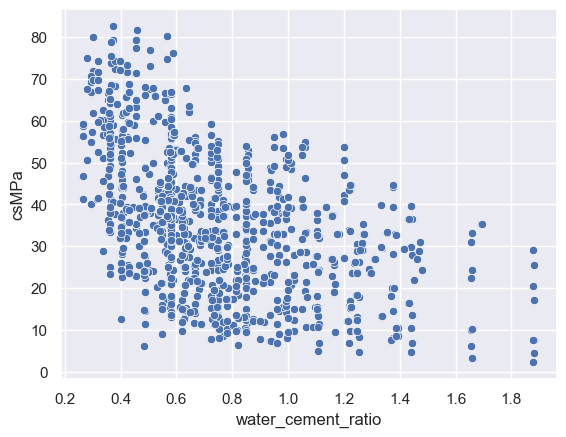

In [32]:
plt.figure()
sns.scatterplot(x=X["water_cement_ratio"], y=Y)
plt.show()

In [35]:
X_sm = sm.add_constant(X)
model = sm.OLS(Y, X_sm)

print(model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  csMPa   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     183.6
Date:                dom, 06 abr 2025   Prob (F-statistic):          2.28e-206
Time:                        17:48:47   Log-Likelihood:                -3865.2
No. Observations:                1030   AIC:                             7750.
Df Residuals:                    1020   BIC:                             7800.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -16.1769     26

In [36]:
X_sm = sm.add_constant(X["water_cement_ratio"])
model = sm.OLS(Y, X_sm)

print(model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  csMPa   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     343.9
Date:                dom, 06 abr 2025   Prob (F-statistic):           1.86e-66
Time:                        17:49:07   Log-Likelihood:                -4212.6
No. Observations:                1030   AIC:                             8429.
Df Residuals:                    1028   BIC:                             8439.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 55.7502      1

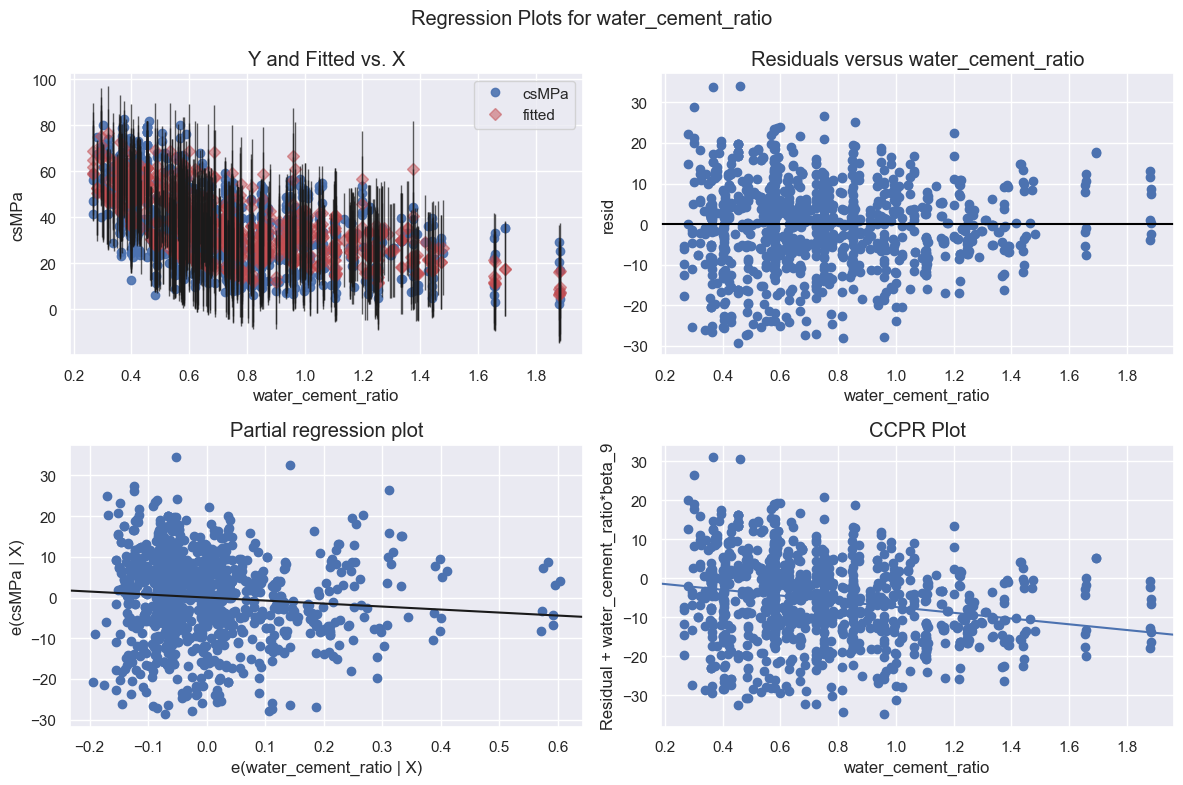

In [39]:
df["water_cement_ratio"] = X["water_cement_ratio"]
model = ols('csMPa ~ cement + slag + flyash + water + superplasticizer + coarseaggregate + fineaggregate + age + water_cement_ratio', data=df).fit()

fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model, "water_cement_ratio", fig=fig)
fig.show()